In [ ]:
# Area code metadata
AREA_CODES = {
    "C4266": {
        "code": "42660",
        "name": "Seattle-Tacoma-Bellevue",
        "state": "WA",
        "region": "Seattle-Tacoma-Bellevue, WA MSA",
        "type": "MSA",
    },
    "C3890": {
        "code": "38900",
        "name": "Portland-Vancouver-Hillsboro",
        "state": "OR-WA",
        "region": "Portland-Vancouver-Hillsboro, OR-WA MSA",
        "type": "MSA",
    },
    "C3346" : {
        "code": "33460",
        "name": "Minneapolis-St Paul-Bloomington",
        "state": "MN-WI",
        "region": "Minneapolis-St Paul-Bloomington, MN-WI MSA",
        "type": "MSA",
    },
    "C1242": {
        "code": "12420",
        "name": "Austin-Round Rock-Georgetown",
        "state": "TX",
        "region": "Austin-Round Rock-Georgetown, TX MSA",
        "type": "MSA",
    },
    "C4790": {
        "code": "47900",
        "name": "Washington-Arlington-Alexandria",
        "state": "DC-VA-MD-WV",
        "region": "Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",
        "type": "MSA",
    }

}

# CBSA code metadata
CBSA_CODES = {
    "42660": {
        "code": "42660",
        "name": "Seattle-Tacoma-Bellevue",
        "state": "WA",
        "type": "MSA",
    },
    "38900": {
        "code": "38900",
        "name": "Portland-Vancouver-Hillsboro",
        "state": "OR-WA",
        "type": "MSA",
    },
    "33460" : {
        "code": "33460",
        "name": "Minneapolis-St Paul-Bloomington",
        "state": "MN-WI",
        "type": "MSA",
    },
    "12420": {
        "code": "12420",
        "name": "Austin-Round Rock-Georgetown",
        "state": "TX",
        "type": "MSA",
    },
    "47900": {
        "code": "47900",
        "name": "Washington-Arlington-Alexandria",
        "state": "DC-VA-MD-WV",
        "type": "MSA",
    }

}

# quarter mapping to month
QUARTER_TO_MONTH = {
    "1": ["01", "02", "03"],
    "2": ["04", "05", "06"],
    "3": ["07", "08", "09"],
    "4": ["10", "11", "12"]
}
# month to quarter mapping
MONTH_TO_QUARTER = {
    "01": "1", 
    "02": "1", 
    "03": "1", 
    "04": "2", 
    "05": "2", 
    "06": "2",   
    "07": "3",
    "08": "3",
    "09": "3",
    "10": "4",
    "11": "4",
    "12": "4"
}      

# Source: BLS Series CUUR0000SA0 (US City Average, All Items) 
# https://data.bls.gov/timeseries/CUUR0000SA0
# Base Period: 1982-84=100
CPI_U = {
    "2014": 236.736,
    "2015": 237.017,
    "2016": 240.007,
    "2017": 245.120,
    "2018": 251.107,
    "2019": 255.657,
    "2020": 258.811,
    "2021": 270.970,
    "2022": 292.655,
    "2023": 304.702,
    "2024": 314.175  # Preliminary 2024 avg (or use Dec 2024 spot)
}

In [19]:
from bls_housing import load_area_df #, get_cached_path , fetch_area_csv
from collections import defaultdict
import pandas as pd

# areas = AREA_CODES["C4266"]["code"] # Seattle-Tacoma-Bellevue MSA
years = ["2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
quarters = ["1", "2", "3", "4"]
# Load DataFrame (uses cache if available)
# get total quarterly wages for MSA for each year and store in total_wages dict

data_list = []

for code in AREA_CODES:
    total_wages = defaultdict(int)

    for year in years:
        for qtr in quarters:
            df = load_area_df(code, year, qtr)
            
            msa = df[df.get('agglvl_code') == 40]
            total_wages_current_qtr = msa['total_qtrly_wages'].iloc[0]
            data_list.append({
                "Area": AREA_CODES[code]["name"],
                "Code": AREA_CODES[code]["code"],
                "Year": year,
                "Quarter": qtr,
                "Total Wages": total_wages_current_qtr
            })
           

# print(data_list)
wages_df = pd.DataFrame(data_list)


# Assume annual_wages_df has columns: ['Year', 'Total Wages']

def adjust_inflation(row):
    year_str = str(row['Year'])
    nominal_wage = row['Total Wages']
    
    if year_str not in CPI_U:
        return nominal_wage # Fallback
        
    cpi_current = CPI_U[year_str]
    cpi_target = CPI_U["2024"] # We normalize everything to 2024 dollars
    
    # The Formula
    real_wage = nominal_wage * (cpi_target / cpi_current)
    return real_wage



# Calculate annual total wages and percentage change
annual_wages_df = wages_df.groupby(["Area", "Code", "Year"])["Total Wages"].sum().reset_index()

# Apply the adjustment
annual_wages_df['Real_Total_Wages'] = annual_wages_df.apply(adjust_inflation, axis=1)

# now calculate the growth rate using the adjusted wages
annual_wages_df['Change_Real_Wage'] = annual_wages_df.groupby("Area")['Real_Total_Wages'].pct_change() * 100
print(annual_wages_df)

#annual_df["Change"] = annual_df.groupby("Code")["Total Wages"].pct_change() * 100
#print(annual_df)

                               Area   Code  Year   Total Wages  \
0      Austin-Round Rock-Georgetown  12420  2014   47842142610   
1      Austin-Round Rock-Georgetown  12420  2015   52029938605   
2      Austin-Round Rock-Georgetown  12420  2016   54683271156   
3      Austin-Round Rock-Georgetown  12420  2017   58821889136   
4      Austin-Round Rock-Georgetown  12420  2018   63586475105   
5      Austin-Round Rock-Georgetown  12420  2019   69861215840   
6      Austin-Round Rock-Georgetown  12420  2020   74347045148   
7      Austin-Round Rock-Georgetown  12420  2021   86539243397   
8      Austin-Round Rock-Georgetown  12420  2022   98564902276   
9      Austin-Round Rock-Georgetown  12420  2023  105404165981   
10     Austin-Round Rock-Georgetown  12420  2024  112635075220   
11  Minneapolis-St Paul-Bloomington  33460  2014  101230858616   
12  Minneapolis-St Paul-Bloomington  33460  2015  106937280270   
13  Minneapolis-St Paul-Bloomington  33460  2016  109991754720   
14  Minnea

In [20]:
# Load cleaned CBSA CSV from cache instead of manual XLS parsing
from bls_housing.census_cache import load_cbsa_df
import pandas as pd

# years = ["2020","2021","2022","2023","2024"]
total_permits = defaultdict(int)
quarters = ["1", "2", "3", "4"]

data_list = []

for code in CBSA_CODES:
    area = CBSA_CODES[code]["code"]
    
    for year in years:
        total_permits[year] = 0
        # print(f"Year: {year}")
        for qtr in quarters:
            for mon in QUARTER_TO_MONTH[qtr]:  # months in quarter
                df = load_cbsa_df(year, str(mon))
                df_current_area = df[df['CBSA'] == int(area)]  # filter for CBSA
                # get total permits for CBSA
                total_permits_current_month = df_current_area['Total'].iloc[0]
                data_list.append({
                    "Area": CBSA_CODES[code]["name"],
                    "Code": code,
                    "Year": year,
                    "Quarter": qtr,
                    "Month": mon,
                    "Total Permits": total_permits_current_month
                })
                
permits_df = pd.DataFrame(data_list)
# print(permits_df)                
    
# Calculate annual total permits and percentage change
annual_permits = permits_df.groupby(["Area", "Code", "Year"])["Total Permits"].sum().reset_index()
annual_permits["Change_permit"] = annual_permits.groupby("Code")["Total Permits"].pct_change() * 100
print(annual_permits)

                               Area   Code  Year  Total Permits  Change_permit
0      Austin-Round Rock-Georgetown  12420  2014        22784.0            NaN
1      Austin-Round Rock-Georgetown  12420  2015        21870.0      -4.011587
2      Austin-Round Rock-Georgetown  12420  2016        22138.0       1.225423
3      Austin-Round Rock-Georgetown  12420  2017        25898.0      16.984371
4      Austin-Round Rock-Georgetown  12420  2018        28778.0      11.120550
5      Austin-Round Rock-Georgetown  12420  2019        31542.0       9.604559
6      Austin-Round Rock-Georgetown  12420  2020        40627.0      28.802866
7      Austin-Round Rock-Georgetown  12420  2021        50297.0      23.801905
8      Austin-Round Rock-Georgetown  12420  2022        42536.0     -15.430344
9      Austin-Round Rock-Georgetown  12420  2023        36300.0     -14.660523
10     Austin-Round Rock-Georgetown  12420  2024        33530.0      -7.630854
11  Minneapolis-St Paul-Bloomington  33460  2014    

In [21]:
final_df = pd.merge(
    annual_wages_df,
    annual_permits,
    on=["Area", "Code", "Year"],
    suffixes=('_wage', '_permit')
)


final_df['Wage_Index'] = 1 + (final_df['Change_Real_Wage'] / 100) # adjusted for inflation
final_df['Permit_Index'] = 1 + (final_df['Change_permit'] / 100)
final_df['Zoning_pressure'] = final_df['Wage_Index'] / final_df['Permit_Index']

print(final_df[['Area', 'Year', 'Zoning_pressure']].sort_values(by=['Area', 'Year']))

                               Area  Year  Zoning_pressure
0      Austin-Round Rock-Georgetown  2014              NaN
1      Austin-Round Rock-Georgetown  2015         1.131641
2      Austin-Round Rock-Georgetown  2016         1.025338
3      Austin-Round Rock-Georgetown  2017         0.900330
4      Austin-Round Rock-Georgetown  2018         0.949623
5      Austin-Round Rock-Georgetown  2019         0.984564
6      Austin-Round Rock-Georgetown  2020         0.816163
7      Austin-Round Rock-Georgetown  2021         0.898015
8      Austin-Round Rock-Georgetown  2022         1.246981
9      Austin-Round Rock-Georgetown  2023         1.203556
10     Austin-Round Rock-Georgetown  2024         1.121999
11  Minneapolis-St Paul-Bloomington  2014              NaN
12  Minneapolis-St Paul-Bloomington  2015         1.058795
13  Minneapolis-St Paul-Bloomington  2016         0.841181
14  Minneapolis-St Paul-Bloomington  2017         0.956737
15  Minneapolis-St Paul-Bloomington  2018         0.8724

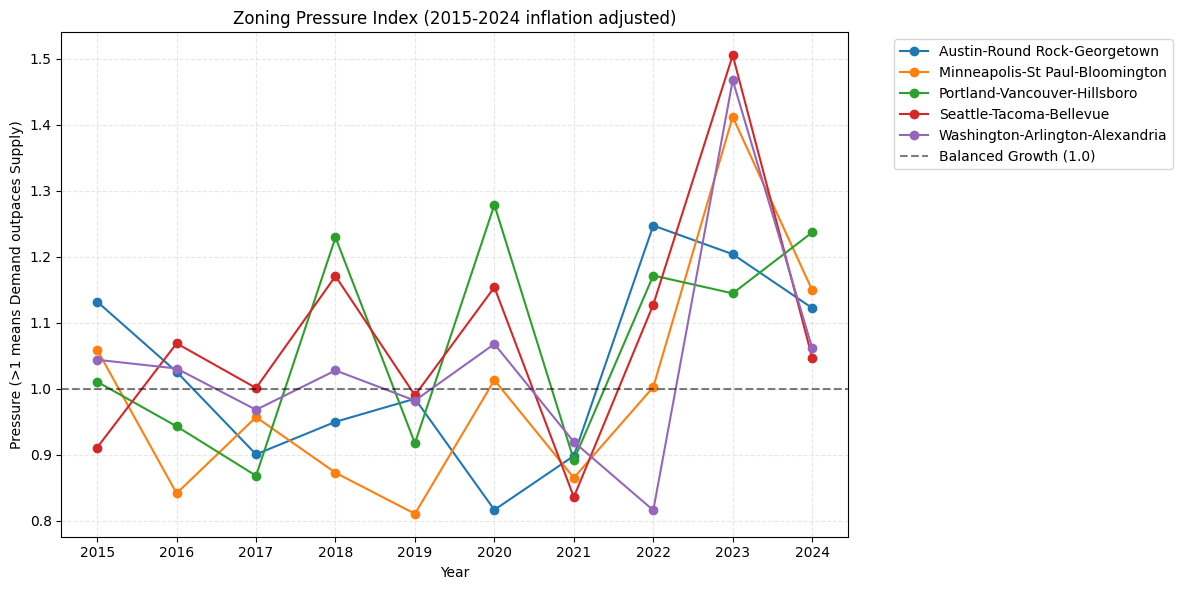

In [22]:
import matplotlib.pyplot as plt
pivot_df = final_df.pivot(index='Year', columns='Area', values='Zoning_pressure')

plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='o', label=column)

plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Balanced Growth (1.0)')

plt.title('Zoning Pressure Index (2015-2024 inflation adjusted)')
plt.ylabel('Pressure (>1 means Demand outpaces Supply)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# 1. Merge the RAW totals (not the % changes)
cumulative_df = pd.merge(
    annual_wages_df[['Area', 'Year', 'Real_Total_Wages']], 
    annual_permits[['Area', 'Year', 'Total Permits']], # Assuming this variable exists
    on=["Area", "Year"]
)

cumulative_df = cumulative_df.loc[(cumulative_df['Year'] > '2014')]

# 2. Define the Base Year (e.g., 2021)
base_year = "2015"
base_data = cumulative_df[cumulative_df['Year'] == base_year].set_index('Area')

# 3. Calculate the Cumulative Growth relative to Base Year
# Formula: (Current Wage / Base Wage)
def get_wage_index(row):
    base_wage = base_data.loc[row['Area'], 'Real_Total_Wages']
    return row['Real_Total_Wages'] / base_wage

def get_permit_index(row):
    base_permit = base_data.loc[row['Area'], 'Total Permits']
    return row['Total Permits'] / base_permit

cumulative_df['Cumul_Wage_Index'] = cumulative_df.apply(get_wage_index, axis=1)
cumulative_df['Cumul_Permit_Index'] = cumulative_df.apply(get_permit_index, axis=1)

# 4. Calculate the Structural Gap
# If Wages are 1.2 (20% growth) and Permits are 1.1 (10% growth), Gap = 1.09
cumulative_df['Structural_Gap'] = cumulative_df['Cumul_Wage_Index'] / cumulative_df['Cumul_Permit_Index']

print(cumulative_df[['Area', 'Year', 'Structural_Gap']].sort_values(['Area', 'Year']))

                               Area  Year  Structural_Gap
1      Austin-Round Rock-Georgetown  2015        1.000000
2      Austin-Round Rock-Georgetown  2016        1.025338
3      Austin-Round Rock-Georgetown  2017        0.923143
4      Austin-Round Rock-Georgetown  2018        0.876638
5      Austin-Round Rock-Georgetown  2019        0.863106
6      Austin-Round Rock-Georgetown  2020        0.704435
7      Austin-Round Rock-Georgetown  2021        0.632594
8      Austin-Round Rock-Georgetown  2022        0.788832
9      Austin-Round Rock-Georgetown  2023        0.949403
10     Austin-Round Rock-Georgetown  2024        1.065230
12  Minneapolis-St Paul-Bloomington  2015        1.000000
13  Minneapolis-St Paul-Bloomington  2016        0.841181
14  Minneapolis-St Paul-Bloomington  2017        0.804789
15  Minneapolis-St Paul-Bloomington  2018        0.702116
16  Minneapolis-St Paul-Bloomington  2019        0.568864
17  Minneapolis-St Paul-Bloomington  2020        0.576165
18  Minneapoli

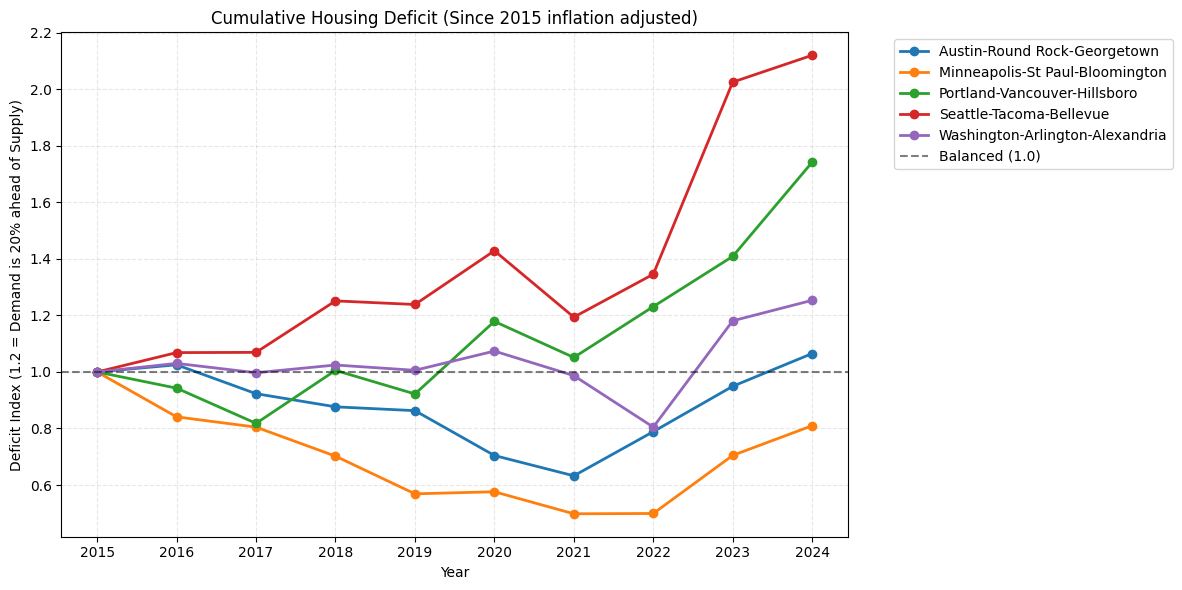

In [24]:
import matplotlib.pyplot as plt

# Pivot for plotting
pivot_gap = cumulative_df.pivot(index='Year', columns='Area', values='Structural_Gap')

plt.figure(figsize=(12, 6))

# Plot lines
for column in pivot_gap.columns:
    plt.plot(pivot_gap.index, pivot_gap[column], marker='o', linewidth=2, label=column)

# Add Reference Line (1.0 = Supply keeping up with Demand)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Balanced (1.0)')

plt.title('Cumulative Housing Deficit (Since 2015 inflation adjusted)')
plt.ylabel('Deficit Index (1.2 = Demand is 20% ahead of Supply)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
import duckdb

con = duckdb.connect(database="../data/analysis.duckdb")
con.execute("CREATE OR REPLACE TABLE annual_metrics AS SELECT * FROM final_df")
con.execute("CREATE OR REPLACE TABLE cumulative_metrics AS SELECT * FROM cumulative_df")
con.execute("CREATE OR REPLACE TABLE wages_metrics AS SELECT * FROM wages_df")
con.execute("CREATE OR REPLACE TABLE permits_metrics AS SELECT * FROM permits_df")
con.close()

In [26]:
# Load cleaned CBSA CSV from cache instead of manual XLS parsing
from bls_housing.census_cache import load_cbsa_df
df = load_cbsa_df('2025', '1')
print(df.keys())
df.head(10)

Index(['CSA', 'CBSA', 'Name', 'Metro /Micro Code', 'Total', '1 Unit',
       '2 Units', '3 and 4 Units', '5 Units or More',
       'Num of Structures With 5 Units or More', 'nan', 'Total_year_to_date',
       '1 Unit_year_to_date', '2 Units_year_to_date',
       '3 and 4 Units_year_to_date', '5 Units or More_year_to_date',
       'Num of Structures With 5 Units or More_year_to_date'],
      dtype='object')


,CSA,CBSA,Name,Metro /Micro Code,Total,1 Unit,2 Units,3 and 4 Units,5 Units or More,Num of Structures With 5 Units or More,nan,Total_year_to_date,1 Unit_year_to_date,2 Units_year_to_date,3 and 4 Units_year_to_date,5 Units or More_year_to_date,Num of Structures With 5 Units or More_year_to_date
0,999,10100,"Aberdeen, SD ...",5,0,0,0,0,0,0,NaN,0,0,0,0,0,0
1,999,10140,"Aberdeen, WA ...",5,24,24,0,0,0,0,NaN,24,24,0,0,0,0
2,101,10180,"Abilene, TX ...",2,82,78,4,0,0,0,NaN,82,78,4,0,0,0
3,999,10220,"Ada, OK ...",5,4,0,4,0,0,0,NaN,4,0,4,0,0,0
4,220,10300,"Adrian, MI ...",5,8,8,0,0,0,0,NaN,8,8,0,0,0,0
5,184,10420,"Akron, OH ...",2,56,42,0,0,14,2,NaN,56,42,0,0,14,2
6,999,10460,"Alamogordo, NM ...",5,1,1,0,0,0,0,NaN,1,1,0,0,0,0
7,999,10480,"Alamosa, CO ...",5,10,6,4,0,0,0,NaN,10,6,4,0,0,0
8,999,10500,"Albany, GA ...",4,6,6,0,0,0,0,NaN,6,6,0,0,0,0
9,440,10540,"Albany, OR ...",2,10,8,2,0,0,0,NaN,10,8,2,0,0,0


In [27]:
# Show cached CSV path
from bls_housing.census_cache import get_cached_csv_path
print(get_cached_csv_path('2025', '1'))


/home/ekang/bls-census-housing-analysis/data/cache/census/csv/CBSA_2025_01.csv


In [28]:
df_current_area = df[df['CBSA'] == 42660]  # filter for Seattle MSA
print(df_current_area)

# get total permits for Seattle MSA
df_Seattle_total_wages = df_current_area['Total'].iloc[0]

#print(df_Seattle_total_wages.columns)
#print(df_Seattle.columns.value_counts())
print(f"[Total: {df_Seattle_total_wages}]")


     CSA   CBSA                                               Name  \
753  500  42660  Seattle-Tacoma-Bellevue, WA                   ...   

     Metro /Micro Code  Total  1 Unit  2 Units  3 and 4 Units  \
753                  2   1203     528       68             78   

     5 Units or More  Num of Structures With 5 Units or More  nan  \
753              529                                      24  NaN   

     Total_year_to_date  1 Unit_year_to_date  2 Units_year_to_date  \
753                1203                  528                    68   

     3 and 4 Units_year_to_date  5 Units or More_year_to_date  \
753                          78                           529   

     Num of Structures With 5 Units or More_year_to_date  
753                                                 24    
[Total: 1203]
